# Customer Segmentation with K-Means

**Goal:** Segment customers based on their **Age**, **Annual Income** and **Spending Score** to discover actionable groups (e.g., VIPs, budget-conscious, potential).

**Dataset:** `Mall_Customers.csv` (Kaggle).  
**Fields:**
- `CustomerID` – identifier (not used for modeling)
- `Gender` – categorical
- `Age` – integer
- `Annual Income (k$)` – annual income in thousand USD
- `Spending Score (1-100)` – higher means stronger spending tendency


In [1]:
# put this in the first cell, before importing numpy/sklearn
import os
os.environ["OMP_NUM_THREADS"] = "1"  # mitigate MKL warning on Windows

os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

## Imports & Global Settings

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12

## Load the dataset
Place `Mall_Customers.csv` in the same folder as this notebook.

In [3]:
DATA_FILE = "Mall_Customers.csv"
assert os.path.exists(DATA_FILE), "Cannot find Mall_Customers.csv. Please put it in this directory."
df = pd.read_csv(DATA_FILE)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Quick data check
We inspect schema and descriptive statistics to understand ranges and potential issues.

In [4]:
print("Info:")
print(df.info())
print("\nDescribe:")
df.describe()

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Describe:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## Light cleaning and column rename
We drop missing rows (if any) and rename columns for convenience.

In [5]:
df = df.dropna().copy()
df = df.rename(columns={
    'Annual Income (k$)': 'Income',
    'Spending Score (1-100)': 'Score'
})
df.head()

,CustomerID,Gender,Age,Income,Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Exploratory data analysis (EDA)
Distributions of `Age`, `Income`, `Score` and their relationships.

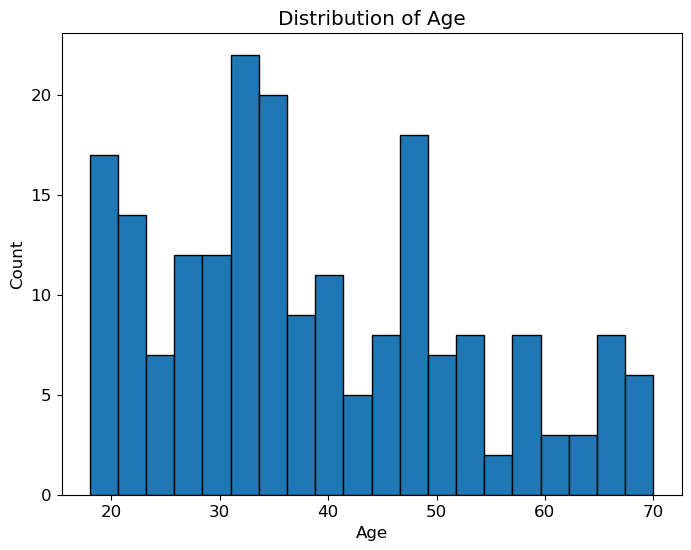

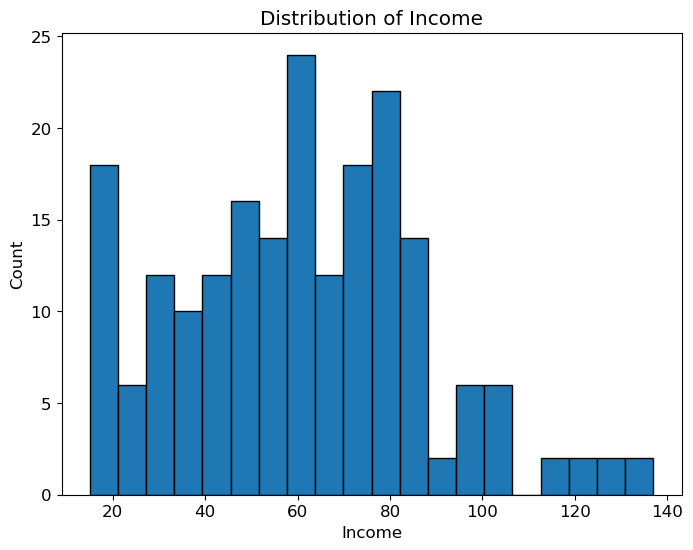

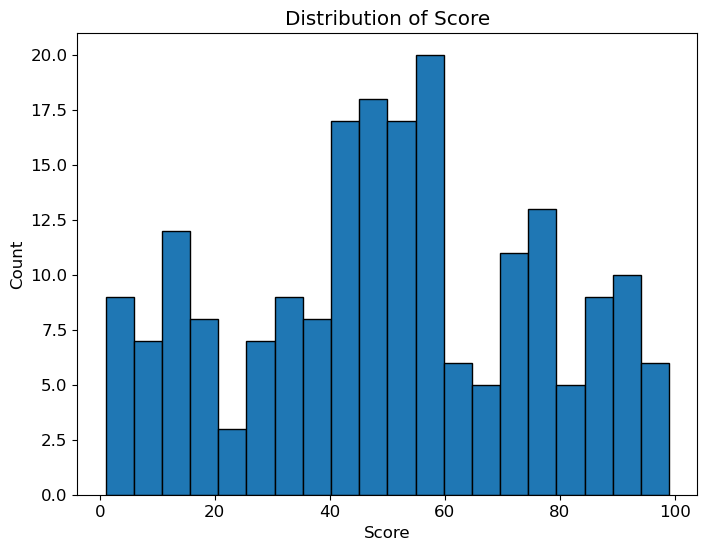

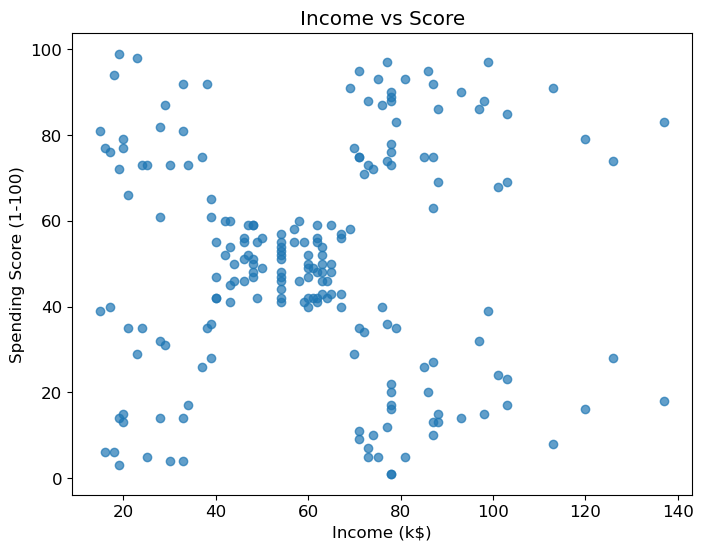

In [6]:
for col in ['Age','Income','Score']:
    plt.figure()
    plt.hist(df[col], bins=20, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col); plt.ylabel('Count')
    plt.show()

plt.figure()
plt.scatter(df['Income'], df['Score'], alpha=0.7)
plt.xlabel('Income (k$)'); plt.ylabel('Spending Score (1-100)')
plt.title('Income vs Score')
plt.show()

## Feature selection & scaling
We use `Age`, `Income`, and `Score`. Standardization is required for K-Means.

In [7]:
FEATURES = ['Age','Income','Score']   # or try ['Income','Score']
X = df[FEATURES].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features:", FEATURES, " -> Scaled shape:", X_scaled.shape)

Features: ['Age', 'Income', 'Score']  -> Scaled shape: (200, 3)


## Choosing the number of clusters (k)
We plot the Elbow curve (SSE). Look for the "elbow" where marginal gain diminishes.

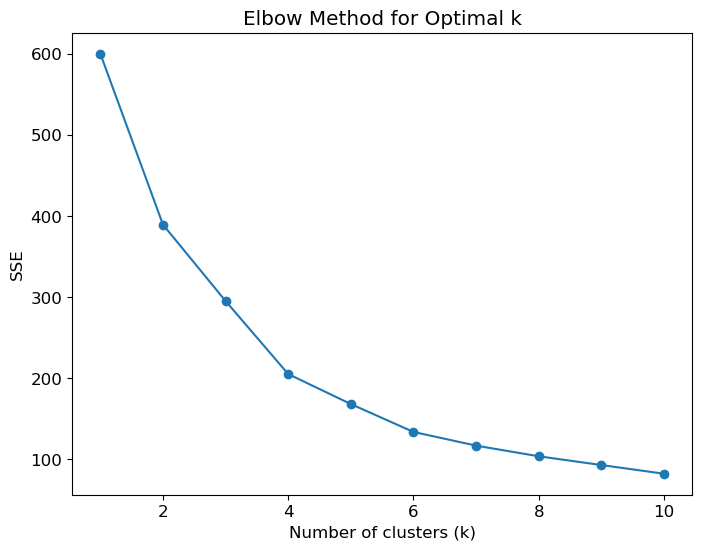

[599.9999999999999,
 389.38618895643714,
 295.21224615554877,
 205.22514747675913,
 168.2475801755683,
 133.86842085478855,
 117.01155455889815,
 103.87329152383714,
 93.0928911004172,
 82.38515364526597]

In [8]:
sse = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    sse.append(km.inertia_)

plt.plot(list(K_range), sse, marker='o')
plt.xlabel('Number of clusters (k)'); plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

sse

## Train K-Means
Pick k (4 or 5 for this dataset) and fit the model.

In [9]:
K = 5  # we pick 5
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

df['Cluster'] = labels
df['Cluster'].value_counts().sort_index()

Cluster
0    20
1    54
2    40
3    39
4    47
Name: count, dtype: int64

## Cluster centers (original scale)
Transform centers back to the original scale for interpretability.

In [10]:
centers_scaled = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers, columns=FEATURES)
centers_df.index.name = 'Cluster'
centers_df.round(2)

,Age,Income,Score
Cluster,,,
0,46.25,26.75,18.35
1,25.19,41.09,62.24
2,32.88,86.10,81.53
3,39.87,86.10,19.36
4,55.64,54.38,48.85


## Visualization
2D view (`Income` vs `Score`) and an 3D view (`Age`, `Income`, `Score`).

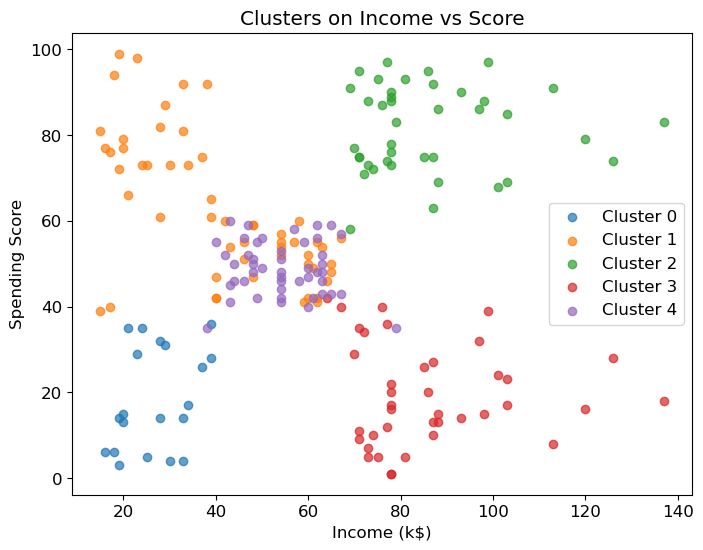

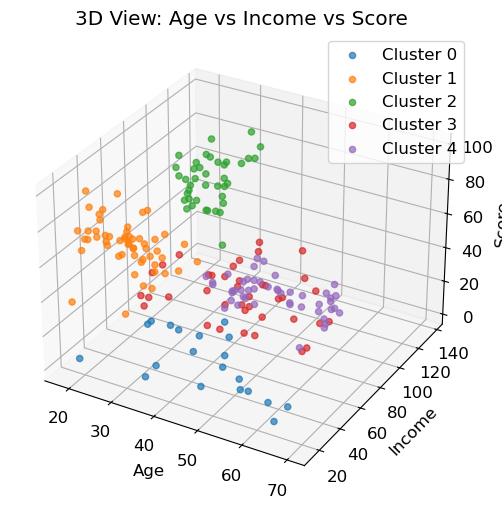

In [11]:
# 2D
plt.figure()
for c in sorted(df['Cluster'].unique()):
    sub = df[df['Cluster']==c]
    plt.scatter(sub['Income'], sub['Score'], alpha=0.7, label=f'Cluster {c}')
plt.xlabel('Income (k$)'); plt.ylabel('Spending Score')
plt.title('Clusters on Income vs Score')
plt.legend(); plt.show()

# 3D 
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')
for c in sorted(df['Cluster'].unique()):
    sub = df[df['Cluster']==c]
    ax.scatter(sub['Age'], sub['Income'], sub['Score'], alpha=0.7, label=f'Cluster {c}')
ax.set_xlabel('Age'); ax.set_ylabel('Income'); ax.set_zlabel('Score')
ax.set_title('3D View: Age vs Income vs Score'); ax.legend(); plt.show()

## Cluster profiling
Summaries (mean/median/min/max/count) per cluster and a simple mean bar chart.

In [12]:
profile = df.groupby('Cluster')[['Age','Income','Score']].agg(['mean','median','min','max','count']).round(2)
profile

Age                      Income                        Score  \
          mean median min max count   mean median min  max count   mean   
Cluster                                                                   
0        46.25   47.0  20  67    20  26.75   26.5  16   39    20  18.35   
1        25.19   24.0  18  38    54  41.09   40.0  15   67    54  62.24   
2        32.88   32.0  27  40    40  86.10   78.5  69  137    40  81.53   
3        39.87   41.0  19  59    39  86.10   78.0  64  137    39  19.36   
4        55.64   54.0  40  70    47  54.38   54.0  38   79    47  48.85   

                              
        median min max count  
Cluster                       
0         14.5   3  36    20  
1         58.0  39  99    54  
2         83.0  58  97    40  
3         17.0   1  42    39  
4         48.0  35  60    47

,Age,Income,Score
Cluster,,,
0,46.25,26.75,18.35
1,25.19,41.09,62.24
2,32.88,86.10,81.53
3,39.87,86.10,19.36
4,55.64,54.38,48.85


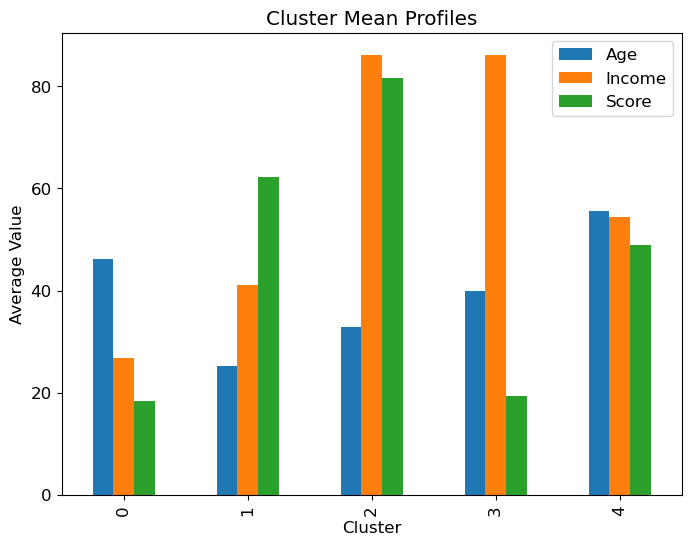

In [13]:
summary = df.groupby('Cluster')[['Age','Income','Score']].mean().round(2)
display(summary)

summary.plot(kind='bar')
plt.title('Cluster Mean Profiles'); plt.ylabel('Average Value')
plt.show()

## Brief Findings

- **Cluster 1 – VIP Spenders (High income • High score):** exclusives, early access, premium bundles.
- **Cluster 2 – Aspirational (Low income • High score):** entry-tier SKUs, BNPL/instalments, gamified rewards; watch margin.
- **Cluster 3 – Affluent Frugal (High income • Low score):** value-proof messaging, targeted reactivation, high-consideration offers.
- **Cluster 0 – Mainstream (Mid income • Mid score):** seasonal promos, cross/upsell, free-shipping thresholds.
- **Cluster 4 – Value-Conscious (Low income • Low score):** price-led packs, basics, low-cost retention; limit paid UA.

